In [40]:
from pathlib import Path
import pandas as pd
from glob import glob
import os
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk import pos_tag

In [41]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('words')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/swastik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/swastik/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/swastik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/swastik/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Importing the data
This code loops from the folders of TXT and takes every .txt file that does not start with ._ which contain the speeches per country per year. These are then added to a dataframe, storing the year, country code and the speech

In [ ]:
path = Path("/home/swastik/Downloads/UNGDC_1946-2024(1)/TXT")##your file path

name_text = []
for folder in path.iterdir():
    if folder.is_dir():
        files = [f for f in folder.glob("*.txt") if not f.name.startswith("._")]

        for file in files:
            name = file.name
            text = file.read_text(encoding="utf-8")
            
            name_text.append({
                        "country": name[:3],
                        "year": name[-8:-4],
                        "speech": text
                    })
    
df = pd.DataFrame(name_text)

df.head(5)

,country,year,speech
0,YEM,2013,"Allow \nme, at the outset to extend sincere my..."
1,NER,2013,It is a great \nhonour for me to take the floo...
2,SWZ,2013,It is a great pleasure for me to have \nthis o...
3,MNG,2013,Allow me to first congratulate \nMr. John Ashe...
4,SGP,2013,I warmly \ncongratulate Mr. John Ashe on his e...


In [43]:
df.tail(5)

,country,year,speech
3283,DEU,2019,"Here in New York over the past few days, we ha..."
3284,MKD,2019,My country has been a Member of the United Nat...
3285,LAO,2019,"At the outset, I would like to congratulate Pr..."
3286,GUY,2019,I bring to President Tijjani Muhammad-Bande fr...
3287,GRD,2019,I extend cordial greetings from the Government...


## Punctuation - Stopwords - Tokenizing
The following code removes all punctuation from the texts, it also tokenizes the string (returns a list of each word separately as a string) and removes stopwords from it and non alphabetical tokens

https://www.geeksforgeeks.org/nlp/removing-stop-words-nltk-python/ 

https://www.geeksforgeeks.org/python/python-remove-punctuation-from-string/

We also remove words that are related to countries as can be found in the CSV file

https://en.wikipedia.org/wiki/List_of_adjectival_and_demonymic_forms_for_countries_and_nations

In [44]:
countries_df = pd.read_csv("List_of_adjectival_and_demonymic_forms_for_countries_and_nations_1.csv")
countries_flat = countries_df.values.ravel().tolist()
countries = []

def split_small_capital(text):
    split = re.sub(r'([a-z])([A-Z])', r'\1 \2', text).split()
    countries.extend(split)

for country_adj in countries_flat: split_small_capital(country_adj)

countries = [country.lower()for country in countries]

In [45]:

stop_words = set(stopwords.words('english'))
english_vocab = set(words.words())

df_tokenize = df.copy()

def punc_stop_token_english(speech: str):
    # Remove punctuation
    speech_no_punctuation = re.sub(r'[^\w\s]', '', speech)
    
    # Tokenize and lowercase
    tokens = word_tokenize(speech_no_punctuation.lower())
    
    # POS tagging
    pos_tags = pos_tag(tokens)
    
    # Keep only words that:
    # - are alphabetic
    # - are not stopwords
    # - are not proper nouns (NNP, NNPS)
    # - are in English vocabulary
    new_speech = [
        word for word, tag in pos_tags
        if (word.isalpha()) 
        and (word not in stop_words)
        and (word not in countries)
        and (tag not in ['NNP', 'NNPS'])
        and (word in english_vocab)
    ]
    
    return new_speech

# Apply to your dataframe
df_tokenize['speech_token'] = df_tokenize['speech'].apply(punc_stop_token_english)
df_tokenize.head(5)
dfwithspeeech = df_tokenize.copy()

In [46]:
# --- Bigram frequency check (after tokenization) ---
from collections import Counter
from nltk import ngrams

all_bigrams = []
for tokens in df_tokenize['speech_token']:   # your tokens are in this column
    if isinstance(tokens, list):
        all_bigrams.extend(list(ngrams(tokens, 2)))

bigram_counts = Counter(all_bigrams)

print("Top 20 most common bigrams:")
for (w1, w2), cnt in bigram_counts.most_common(20):
    print(f"{w1} {w2:<20} {cnt}")

Top 20 most common bigrams:
climate change               8947
sustainable development          7609
general assembly             7281
international community            7277
security council              6496
peace security             5438
per cent                 3957
would like                 3841
international law                  2820
international peace                2015
rule law                  1902
let us                   1807
assembly session              1718
millennium development          1553
economic social               1551
development agenda               1510
president general              1453
around world                1364
agenda sustainable          1364
session general              1335


## Polarization score

In [47]:
polarization_df = pd.read_csv("political-polarization-score.csv")
polarization_df.head()

polarization_df.columns = polarization_df.columns.str.lower()

bounds = [ -3, -1, 1, 3]

labels = [
    "Stable",
    "Neutral",
    "Polarized"
]

polarization_df["polarization label"] = pd.cut(
    polarization_df["political polarization score (central estimate)"],
    bins=bounds,
    labels=labels,
    include_lowest=True,
    right=False
)
polarization_df = polarization_df.rename(columns={"code": "country"})


polarization_df

,entity,country,year,political polarization score (central estimate),polarization label
0,Afghanistan,AFG,1992,2.775,Polarized
1,Afghanistan,AFG,1993,2.775,Polarized
2,Afghanistan,AFG,1994,2.775,Polarized
3,Afghanistan,AFG,1995,2.775,Polarized
4,Afghanistan,AFG,1996,2.775,Polarized
...,...,...,...,...,...
22674,Zimbabwe,ZWE,2020,2.499,Polarized
22675,Zimbabwe,ZWE,2021,2.066,Polarized
22676,Zimbabwe,ZWE,2022,1.551,Polarized
22677,Zimbabwe,ZWE,2023,1.984,Polarized


In [48]:
for df in (df_tokenize, polarization_df):
    df['country'] = df['country'].astype(str).str.strip()
    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

bad_tf = df_tokenize[df_tokenize['year'].isna()]
bad_pol = polarization_df[polarization_df['year'].isna()]

merged_df = df_tokenize.merge(
    polarization_df,
    how='right',
    on=['country', 'year']
)
merged_df = merged_df.dropna()
merged_df

,country,year,speech,speech_token,entity,political polarization score (central estimate),polarization label
16,AFG,2008,Since the last time we \ngathered here in this...,"[since, last, time, hall, year, grave, glory, ...",Afghanistan,-0.014,Neutral
17,AFG,2009,"First, I would like to \ncongratulate His Exce...","[first, would, like, congratulate, excellency,...",Afghanistan,-0.014,Neutral
18,AFG,2010,I join previous \nspeakers in congratulating y...,"[join, previous, sir, election, president, gen...",Afghanistan,-0.014,Neutral
19,AFG,2011,I am honoured to be \nhere to read the stateme...,"[read, statement, president, excellency, retur...",Afghanistan,-0.014,Neutral
20,AFG,2012,"﻿As we speak today, the world\nis being shaken...","[speak, today, world, shaken, depravity, insul...",Afghanistan,-0.014,Neutral
...,...,...,...,...,...,...,...
22674,ZWE,2020,"Your Excellency, Ambassador Volkan Bozkir, Pre...","[excellency, ambassador, president, session, g...",Zimbabwe,2.499,Polarized
22675,ZWE,2021,"Your Excellency Abdulla Shahid, President of t...","[excellency, president, session, general, asse...",Zimbabwe,2.066,Polarized
22676,ZWE,2022,It is my singular honour to deliver this state...,"[singular, deliver, statement, assembly, allow...",Zimbabwe,1.551,Polarized
22677,ZWE,2023,I wish to congratulate Mr. Dennis Francis on h...,"[wish, congratulate, election, president, gene...",Zimbabwe,1.984,Polarized


## TF-IDF
The following code calculates the TF-IDF score for each word in every speech, this is then stored in the Dataframe as a list of pairs, containing (word, tf-idf score), sorted descendingly, so you get the higher TF-IDF scores first

https://www.geeksforgeeks.org/machine-learning/understanding-tf-idf-term-frequency-inverse-document-frequency/

In [49]:
df_tf_idf = merged_df.copy()

df_tf_idf['speech_token'] = df_tf_idf['speech_token'].str.join(' ')

tfidf_vector = TfidfVectorizer()
speeches = df_tf_idf['speech_token']

tf_idf_matrix  = tfidf_vector.fit_transform(speeches)

In [50]:
print(tf_idf_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1241382 stored elements and shape (2802, 15515)>
  Coords	Values
  (0, 12382)	0.04045690075999833
  (0, 7719)	0.09321682884592405
  (0, 13764)	0.03275174286148552
  (0, 6088)	0.03936284861890148
  (0, 15470)	0.05290632274727406
  (0, 5965)	0.04077561766152469
  (0, 5869)	0.08716087591668245
  (0, 6434)	0.015732740901513824
  (0, 121)	0.07196003323078914
  (0, 12982)	0.0569805777205506
  (0, 6424)	0.05389307355289644
  (0, 815)	0.07651729601956982
  (0, 15399)	0.08418162122967691
  (0, 6022)	0.09288575838945642
  (0, 5860)	0.030193071880911
  (0, 14363)	0.0331716084320022
  (0, 2242)	0.017320744704415972
  (0, 2059)	0.01630488502472526
  (0, 11246)	0.027501661102324288
  (0, 12048)	0.06254340525153379
  (0, 8483)	0.09212688515341948
  (0, 12278)	0.13099622928306476
  (0, 5434)	0.05098859424526216
  (0, 8191)	0.0519241522666581
  (0, 3822)	0.09675153984657162
  :	:
  (2801, 2765)	0.060173819548969006
  (2801, 917)	0.0433579946

In [51]:
feature_names = tfidf_vector.get_feature_names_out()

def matrix_to_tfidf_pairs(row):
    row_array = row.toarray().flatten()  
    word_tf_idf_pairs = [(word, score) for word, score in zip(feature_names, row_array) if score > 0]
    pairs_sorted = sorted(word_tf_idf_pairs, key=lambda x: x[1], reverse=True)
    return pairs_sorted

df_tf_idf['speech_score'] = [matrix_to_tfidf_pairs(tf_idf_matrix[i]) for i in range(tf_idf_matrix.shape[0])]

In [52]:
df_tf_idf[['country', 'year', 'speech_score']].head()

,country,year,speech_score
16,AFG,2008,"[(terrorism, 0.19991946303446514), (developmen..."
17,AFG,2009,"[(intellectual, 0.19834883526657707), (interna..."
18,AFG,2010,"[(jirga, 0.3479360928049011), (allies, 0.17333..."
19,AFG,2011,"[(transition, 0.2167420247831691), (internatio..."
20,AFG,2012,"[(peace, 0.20442307571083534), (security, 0.20..."


In [53]:
# --- TF-IDF with unigrams + bigrams (n-grams) ---
from sklearn.feature_extraction.text import TfidfVectorizer

# use the same joined text you created above
texts = df_tf_idf['speech']  # already ' '.join(tokens)

tfidf_ngram = TfidfVectorizer(
    lowercase=True,
    token_pattern=r"(?u)\b\w+\b",  # keep words and numbers
    ngram_range=(1, 2),            # unigrams + bigrams
    min_df=2,
    max_df=0.9,
)

tf_idf_matrix_ngram = tfidf_ngram.fit_transform(texts)
feature_names_ngram = tfidf_ngram.get_feature_names_out()

print("Docs:", tf_idf_matrix_ngram.shape[0],
      "Vocab size (with bigrams):", tf_idf_matrix_ngram.shape[1])

def matrix_to_tfidf_pairs_ng(row):
    arr = row.toarray().flatten()
    pairs = [(w, s) for w, s in zip(feature_names_ngram, arr) if s > 0]
    return sorted(pairs, key=lambda x: x[1], reverse=True)

# store bigram-aware scores in a NEW column, while keeping original intact
df_tf_idf['speech_score_bigrams'] = [
    matrix_to_tfidf_pairs_ng(tf_idf_matrix_ngram[i])
    for i in range(tf_idf_matrix_ngram.shape[0])
]

# quick peek into the dataframe with speech score for both unigrams AND bigrams
df_tf_idf[['country', 'year', 'speech_score_bigrams']].tail()
df_tf_idf[['country', 'year', 'speech_score_bigrams']].head()


Docs: 2802 Vocab size (with bigrams): 314704


,country,year,speech_score_bigrams
16,AFG,2008,"[(afghanistan, 0.21868512907356213), (afghaniz..."
17,AFG,2009,"[(afghanistan, 0.2835064906001895), (afghan, 0..."
18,AFG,2010,"[(afghanistan, 0.28287871573275675), (of afgha..."
19,AFG,2011,"[(afghanistan, 0.28333789289615685), (afghan, ..."
20,AFG,2012,"[(afghan, 0.213954113940886), (the afghan, 0.1..."


## Linear Regression - Lasso

https://scikit-learn.org/stable/modules/linear_model.html

In [62]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

Mean Squared Error: 0.12762329225972943
Mean Absolute Error: 0.28858251825459375
R^2 Score: 0.33486596283331815


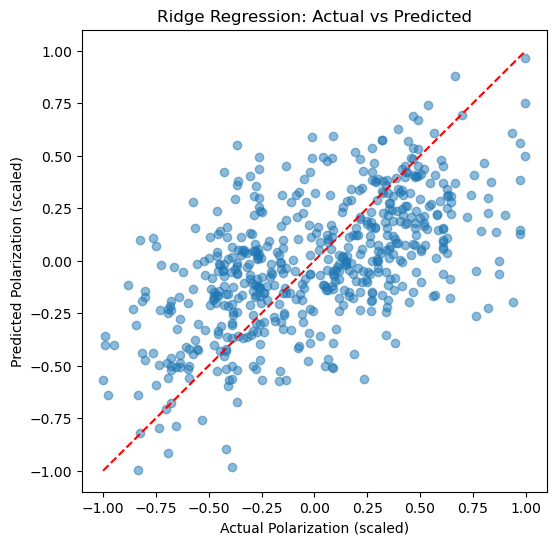

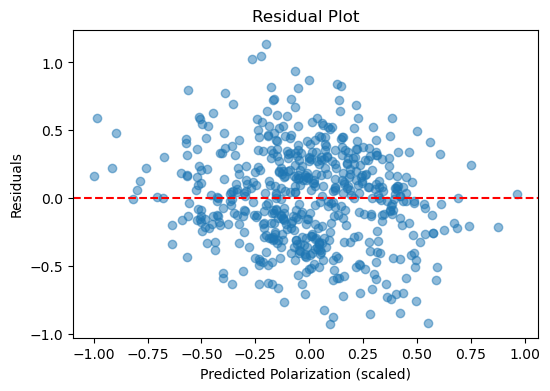

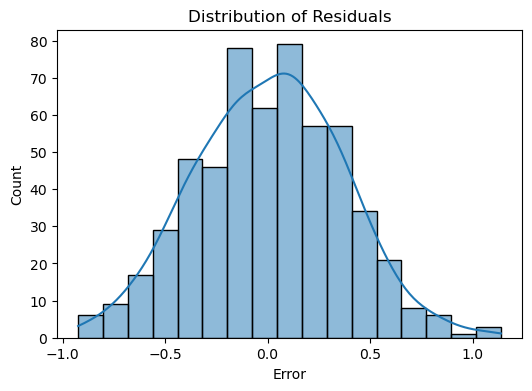

In [68]:
df_lin = merged_df.copy()
df_lin = df_lin.rename(columns={"political polarization score (central estimate)": "polarization score"})

y = np.array(df_lin["polarization score"]).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaled = scaler.fit_transform(y)

df_lin["polarization scaled"] = y_scaled


X = tf_idf_matrix
y = df_lin['polarization scaled']
# y = df_lin['polarization score']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_lin = linear_model.Ridge(alpha=0.1)
model_lin.fit(X_train, y_train)

y_pred = model_lin.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", MSE)
print("Mean Absolute Error:", MAE)
print("R^2 Score:", r2)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Polarization (scaled)")
plt.ylabel("Predicted Polarization (scaled)")
plt.title("Ridge Regression: Actual vs Predicted")
plt.plot([-1, 1], [-1, 1], color='red', linestyle='--')  # perfect fit line
plt.show()

# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Polarization (scaled)")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# 3. Residual Distribution
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Error")
plt.show()

## Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [69]:
X = tf_idf_matrix
y = merged_df['polarization label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/home/swastik/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.5775401069518716
              precision    recall  f1-score   support

     Neutral       0.53      0.92      0.67       260
   Polarized       0.65      0.17      0.27       152
      Stable       0.82      0.40      0.53       149

    accuracy                           0.58       561
   macro avg       0.67      0.50      0.49       561
weighted avg       0.64      0.58      0.53       561



## Happiness Report


In [59]:
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize


# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()
# Apply sentiment analysis to each speech

dataframe = df.copy()
print("hey",dataframe)

happinessdataframe = pd.read_excel('DataForTable2.1.xls')
happinessdataframe
happinesmergeddf = merged_df.merge(
    happinessdataframe,
    left_on=['entity', 'year'],
    right_on=['Country name', 'year'],
    how='inner'   # or 'outer' / 'left' depending on what you need
)
scaler = MinMaxScaler(feature_range=(-1, 1))

# Select the columns to be normalized
columns_to_normalize = ['political polarization score (central estimate)', 'Life Ladder']

# Fit the scaler to the data and transform the columns
happinesmergeddf[columns_to_normalize] = scaler.fit_transform(happinesmergeddf[columns_to_normalize])

# Initialize the VADER analyzer
sia = SentimentIntensityAnalyzer()

# Assuming your DataFrame is named 'happinessmergeddf'
# and the column with speeches is named 'speech'

def get_average_sentiment(speech):
    """
    Calculates the average compound sentiment score for a given speech by
    analyzing it sentence by sentence.
    """
    # Check if the input is a valid string
    if not isinstance(speech, str) or not speech.strip():
        return 0.0  # Return a neutral score for empty or invalid input

    # Tokenize the speech into sentences
    sentences = sent_tokenize(speech)

    # If no sentences are found, return a neutral score
    if not sentences:
        return 0.0

    # Calculate the compound score for each sentence
    compound_scores = [sia.polarity_scores(sentence)['compound'] for sentence in sentences]
    compound_scores.sort()
    lowest = compound_scores[:5]      # first 5 elements
    highest = compound_scores[-5:]    # last 5 elements
# Combine them into a new variable (list)
    result = lowest + highest
    # Calculate the average of all compound scores
    average_score = sum(result) / len(result)

    return average_score

# Apply the function to the 'speech' column and create a new 'sentiment' column
happinesmergeddf['sentiment'] = dfwithspeeech['speech'].apply(get_average_sentiment)

# Print the final DataFrame with normalized values
print("DataFrame with normalized columns (range -1 to 1):")
# print(happinesmergeddf[columns_to_normalize])
columns_to_show = ['political polarization score (central estimate)', 'Life Ladder','country','sentiment']
happinesmergeddf[columns_to_show]

hey             entity country  year  \
0      Afghanistan     AFG  1992   
1      Afghanistan     AFG  1993   
2      Afghanistan     AFG  1994   
3      Afghanistan     AFG  1995   
4      Afghanistan     AFG  1996   
...            ...     ...   ...   
22674     Zimbabwe     ZWE  2020   
22675     Zimbabwe     ZWE  2021   
22676     Zimbabwe     ZWE  2022   
22677     Zimbabwe     ZWE  2023   
22678     Zimbabwe     ZWE  2024   

       political polarization score (central estimate) polarization label  
0                                                2.775          Polarized  
1                                                2.775          Polarized  
2                                                2.775          Polarized  
3                                                2.775          Polarized  
4                                                2.775          Polarized  
...                                                ...                ...  
22674                          

,political polarization score (central estimate),Life Ladder,country,sentiment
0,-0.014689,-0.466589,AFG,0.05797
1,-0.014689,-0.232411,AFG,0.05637
2,-0.014689,-0.109277,AFG,0.04129
3,-0.014689,-0.429252,AFG,0.13260
4,-0.014689,-0.446096,AFG,0.03041
...,...,...,...,...
1949,0.833868,-0.822270,ZWE,0.05416
1950,0.833868,-0.661264,ZWE,0.02036
1951,0.687658,-0.663068,ZWE,0.18053
1952,0.513760,-0.614159,ZWE,0.07695


Samples used: 1954
Pearson r: -0.0115

Linear regression:  Yi = intercept + slope * Xi
  intercept: -0.014314
  slope:     -0.067608
  R^2:       0.0001
  p-value:   0.610593
  std_err:   0.132745


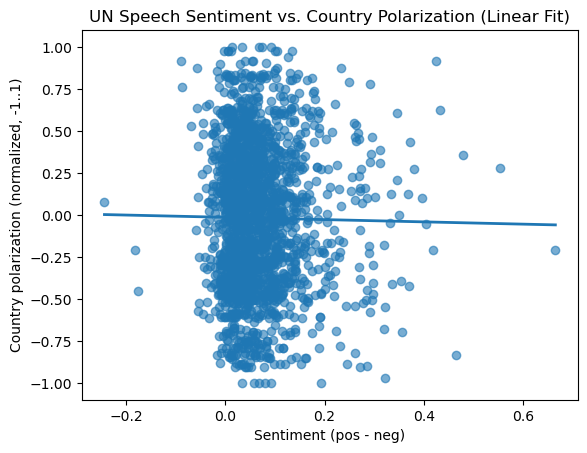

In [60]:
from scipy.stats import pearsonr, linregress

nltk_df = happinesmergeddf.copy()

# Reshape polarization from [-3,3] to [-1,1]
y = np.array(nltk_df["political polarization score (central estimate)"]).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaled = scaler.fit_transform(y)

nltk_df["political polarization score (central estimate)"] = y_scaled

# Regression code
Xi = nltk_df['sentiment'].values
Yi = nltk_df["political polarization score (central estimate)"].values

# Pearson linear regression
pearson_r, p_val = pearsonr(Xi, Yi)

# Simple linear regression Yi = a + b * Xi 
slope, intercept, r_value, p_value, std_err = linregress(Xi, Yi)

print(f"Samples used: {len(nltk_df)}")
print(f"Pearson r: {pearson_r:.4f}")
print("\nLinear regression:  Yi = intercept + slope * Xi")
print(f"  intercept: {intercept:.6f}")
print(f"  slope:     {slope:.6f}")
print(f"  R^2:       {r_value**2:.4f}")
print(f"  p-value:   {p_value:.6g}")
print(f"  std_err:   {std_err:.6f}")

#  Quick scatter + fitted line
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(Xi, Yi, alpha=0.6)
xline = np.linspace(Xi.min(), Xi.max(), 200)
yline = intercept + slope * xline
plt.plot(xline, yline, linewidth=2)
plt.xlabel("Sentiment (pos - neg)")
plt.ylabel("Country polarization (normalized, -1..1)")
plt.title("UN Speech Sentiment vs. Country Polarization (Linear Fit)")
plt.show()

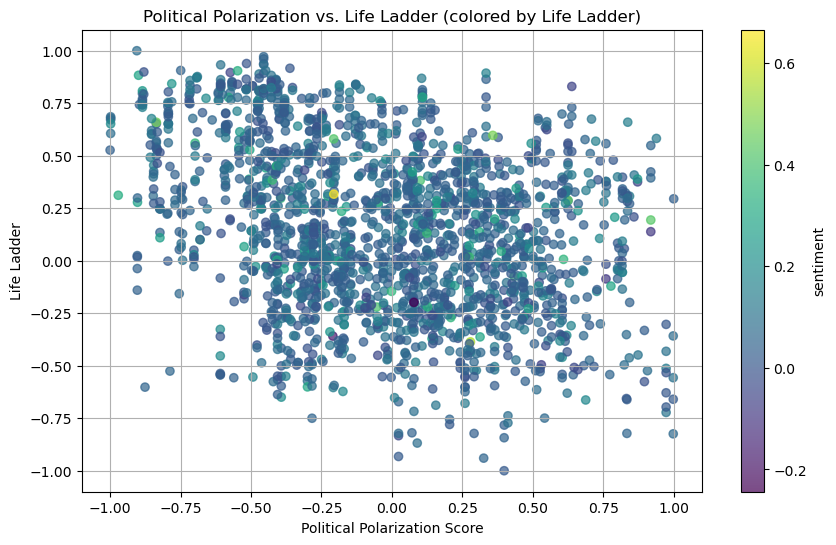

In [61]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'happinesmergeddf'
# And the columns are correctly named as in the image

# Plot: Political Polarization vs. Life Ladder, colored by Sentiment
plt.figure(figsize=(10, 6))
plt.scatter(
    happinesmergeddf['political polarization score (central estimate)'],
    happinesmergeddf['Life Ladder'],
    c=happinesmergeddf['sentiment'], # Use sentiment for color
    cmap='viridis',                  # Choose a color map
    alpha=0.7                        # Adjust transparency
)

# Add a color bar to explain the sentiment values
cbar = plt.colorbar()
cbar.set_label('sentiment')

# Set labels and title
plt.xlabel('Political Polarization Score')
plt.ylabel('Life Ladder')
plt.title('Political Polarization vs. Life Ladder (colored by Life Ladder)')

plt.grid(True)
plt.show()